In [ ]:
pip install indic-nlp-library

     |████████████████████████████████| 40 kB 3.4 MB/s 
     |████████████████████████████████| 2.8 MB 8.8 MB/s 


In [ ]:
import pandas as pd
from collections import Counter
import numpy as np
np.random.seed(10)
import pandas as pd
import numpy as np
import torch
from torch.nn import *
from torch import nn
import torch.nn.functional as f
from torch.optim.lr_scheduler import *
from collections import Counter
from torchtext.data.utils import get_tokenizer
from tqdm import notebook
from torchtext.vocab import *
from torch.utils.data import *
torch.manual_seed(42)

In [ ]:
import sys
from indicnlp import common

# The path to the local git repo for Indic NLP library
INDIC_NLP_LIB_HOME=r"indic_nlp_library"

# The path to the local git repo for Indic NLP Resources
INDIC_NLP_RESOURCES=r"indic_nlp_resources"

# Add library to Python path
sys.path.append(r'{}\src'.format(INDIC_NLP_LIB_HOME))

# Set environment variable for resources folder
common.set_resources_path(INDIC_NLP_RESOURCES)


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/SentiMent_Analysis/final_data.csv")

In [ ]:
data["sentiment"] =data["sentiment"].map({
    "Happy":1,
    "Sad":0,
    "Sadness":0,
    "Anger":0
})

In [ ]:
data1 = pd.read_csv("/content/drive/MyDrive/SentiMent_Analysis/processed_telugu.csv")

In [ ]:


data = pd.concat((data, data1),ignore_index=True)

In [ ]:
data = data.iloc[np.random.permutation(data.shape[0])]

In [ ]:
data.shape

(1977, 2)

In [ ]:
data.dropna(inplace=True)

In [ ]:
data.shape

(1976, 2)

In [ ]:
data.drop_duplicates(inplace=True)

In [ ]:
data.shape

(1961, 2)

In [ ]:
from indicnlp.tokenize import sentence_tokenize
from indicnlp.tokenize import indic_tokenize  
def text_processor(sentence):
    sent = []
    for token in indic_tokenize.trivial_tokenize(str(sentence)): 
        sent.append(str(token))
    return sent

In [ ]:
from sklearn.model_selection import train_test_split
train_data,test_data = train_test_split(data,test_size=0.15,random_state=1)

In [ ]:
print(train_data.sentiment.value_counts(),test_data.sentiment.value_counts())

0    854
1    812
Name: sentiment, dtype: int64 1    164
0    131
Name: sentiment, dtype: int64


In [ ]:
counter = Counter()
tokenizer = get_tokenizer(text_processor)
with tqdm.notebook.trange(data.shape[0]) as progres_bar:
    for i in progres_bar:
        progres_bar.set_description(f"Vocab Builder")
        counter.update(tokenizer(str(data["tweet"].iloc[i])))

In [ ]:
from torchtext.vocab import *
from torch.utils.data import *

In [ ]:
vocabulary = vocab(counter, min_freq=2)

In [ ]:
vocabulary.insert_token("<pad>",0)
vocabulary.insert_token("<unk>",1)
vocabulary.insert_token("<sos>",2)
vocabulary.insert_token("<eos>",3)
vocabulary.set_default_index(1)
print("Additional Words: ", vocabulary.lookup_tokens([0,1,2,3]))
print("Vocab Size: ", len(vocabulary))

Additional Words:  ['<pad>', '<unk>', '<sos>', '<eos>']
Vocab Size:  4


In [ ]:
class TokenDataset(Dataset):
    def __init__(self, X, Y, vocab, max_length, tokenizer):
        self.X = X
        self.Y = Y
        self.vocab = vocab
        self.max_length = max_length
        self.tokenizer = tokenizer
    def __getitem__(self, i):
        tokens = [2]+self.lookup_idx(self.X.iloc[i])
        size = min(len(tokens), self.max_length)
        ids = np.zeros((self.max_length), dtype=np.int64)
        masks =  np.ones((self.max_length), dtype=np.bool_)
        ids[:size] = tokens[:size]
        ids[size-1] = 3
        masks[:size] = False
        return (
            torch.from_numpy(ids),
            torch.from_numpy(masks),
            torch.tensor(self.Y.iloc[i])
        )
    def __len__(self):
        return self.X.shape[0]
    def lookup_idx(self,sentence):
        return self.vocab(self.tokenizer(sentence))


In [ ]:
MAX_LENGTH = 72
train_ds = TokenDataset(
                        X = train_data["tweet"], 
                        Y = train_data["sentiment"], 
                        vocab = vocabulary, 
                        max_length = MAX_LENGTH,
                        tokenizer = text_processor)
test_ds = TokenDataset(
                        X = test_data["tweet"], 
                        Y = test_data["sentiment"], 
                        vocab = vocabulary, 
                        max_length = MAX_LENGTH,
                       tokenizer = text_processor)

72


(array([34., 70., 31., 37., 17.,  7.,  7.,  8.,  7., 77.]),
 array([ 2.,  9., 16., 23., 30., 37., 44., 51., 58., 65., 72.]),
 <a list of 10 Patch objects>)

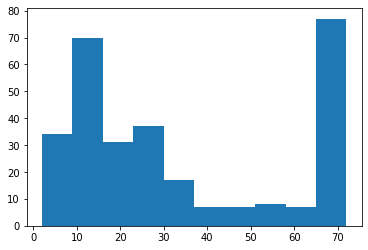

In [ ]:
ds = test_ds
shapes = []
for i in range(0,len(ds)):
    shapes.append(MAX_LENGTH - train_ds[i][1].sum().item())
print(max(shapes))
import matplotlib.pyplot as plt
plt.hist(shapes)

In [ ]:
train_dl = DataLoader(train_ds, batch_size=64)
test_dl = DataLoader(test_ds, batch_size=64)

In [ ]:
class TransformerRNN(nn.Module):
    def __init__(
        self, vocab_size, embed_dim, n_heads,
        n_feed, dropout, n_layers, seq_length, hidden_size
        ):

        super(TransformerRNN, self).__init__()
        
        self.embed_dim = embed_dim

        self.embedding = nn.Embedding(vocab_size,
                                      embedding_dim=self.embed_dim,
                                      padding_idx=0)
        

        self.trans_enc_layer = nn.TransformerEncoderLayer(
                                d_model = self.embed_dim,
                                nhead = n_heads,
                                dim_feedforward = n_feed,
                                dropout = dropout,
                                batch_first = True,
                                )
        
        self.trans_encoder = nn.TransformerEncoder(
                                encoder_layer = self.trans_enc_layer,
                                num_layers = n_layers,
                                )
        

        self.seq_length = seq_length

        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(
                            self.embed_dim, 
                            hidden_size = self.hidden_size, 
                            num_layers=2, 
                            bidirectional=True, 
                            dropout=0.2,
                            batch_first=True)

        self.fc = nn.Linear(self.hidden_size*2, 2)
        

    def forward(self, ids, masks):
        embed_out = self.embedding(ids)
        trans_out = self.trans_encoder(embed_out, src_key_padding_mask = masks)
        out, (hidden, _) = self.lstm(f.relu(trans_out))
        dense_outputs=self.fc(f.relu(out[:,-1,:]))
        return dense_outputs

    


In [ ]:
class TransformerCNN(nn.Module):
    def __init__(
        self,vocab_size, embed_dim, n_heads,
        n_feed, dropout, n_layers, seq_length, kernal_size
        ):

        super(TransformerCNN, self).__init__()
        
        self.embed_dim = embed_dim

        self.embedding = nn.Embedding(vocab_size,
                                      embedding_dim=self.embed_dim,
                                      padding_idx=0)
        

        self.trans_enc_layer = nn.TransformerEncoderLayer(
                                d_model = self.embed_dim,
                                nhead = n_heads,
                                dim_feedforward = n_feed,
                                dropout = dropout,
                                batch_first = True,
                                )
        
        self.trans_encoder = nn.TransformerEncoder(
                                encoder_layer = self.trans_enc_layer,
                                num_layers = n_layers,
                                )
        

        self.seq_length = seq_length

        self.kernal_size = kernal_size
        self.conv_1d = nn.Conv1d(
                                in_channels=self.embed_dim,
                                out_channels = self.seq_length,
                                kernel_size  = kernal_size
                                )


        self.pool_1d = nn.AvgPool1d(kernel_size=self.seq_length-kernal_size)

        self.linear = nn.Linear(self.seq_length, 2)



    def forward(self, ids, masks):

        embed_out = self.embedding(ids)
        trans_out = self.trans_encoder(embed_out, src_key_padding_mask = masks)
        conv_out = self.conv_1d(trans_out.reshape(-1,self.embed_dim, self.seq_length))
        pool_out = self.pool_1d(f.dropout(f.relu(conv_out),0.2))
        final_out = self.linear(f.dropout(f.relu(pool_out.view(-1,self.seq_length)),0.2))
        return final_out


In [ ]:
try: 
    del model
except:
    pass
model = TransformerRNN(
    vocab_size = len(vocabulary),
    embed_dim = 100,
    n_heads = 2,
    n_feed = 512,
    dropout = 0.3, 
    n_layers = 2, 
    seq_length = MAX_LENGTH,
    hidden_size=128
)

model.float()
print("Model Instantiated")

Model Instantiated


In [ ]:
try: 
    del model
except:
    pass
model = TransformerCNN(
    vocab_size = len(vocabulary),
    embed_dim = 100,
    n_heads = 4,
    n_feed = 1024,
    dropout = 0.2, 
    n_layers = 3, 
    seq_length = MAX_LENGTH,
    kernal_size = 3
)
model.float()
print("Model Instantiated")

Model Instantiated


In [ ]:
import torch
import sklearn
from tqdm import notebook
from sklearn import metrics
from torch.optim import *
from torch import nn, optim
import matplotlib.pyplot as plt
torch.manual_seed(0)
class Learner:
    def __init__(self,model:nn.Module,train_dataloader:torch.utils.data.DataLoader,
                 val_dataloader:torch.utils.data.DataLoader,optimizer:optim.Optimizer=Adam,
                 loss_func:torch.nn=nn.CrossEntropyLoss,lr_scheduler:optim.lr_scheduler=None,
                 lr_rate:float=1e-03,metric:sklearn.metrics=metrics.accuracy_score,
                 model_name:str="", is_save:bool = False, n_steps:int = 2, gamma:float=0.5):
        self.device=torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.model=model.to(self.device)
        self.train_dataloader=train_dataloader
        self.val_dataloader=val_dataloader
        self.optimizer=optimizer(self.model.parameters(),lr_rate)
        self.loss_func=loss_func()
        self.lr_scheduler=lr_scheduler(self.optimizer,n_steps,gamma = gamma)
        self.train_loss, self.val_loss, self.train_score, self.val_score=[],[],[],[]
        self.train_pred_label = torch.tensor([])
        self.train_act_label = torch.tensor([])
        self.val_pred_label = torch.tensor([])
        self.val_act_label = torch.tensor([])
        self.metric=metric
        self.is_save = is_save
        self.model_name  = model_name

    def set_act_label(self):
        with notebook.tqdm(enumerate(self.train_dataloader),total=len(self.train_dataloader),leave=False,unit="epoch") as tbatch:
            for i,(_,_,targets) in tbatch:
                self.train_act_label = torch.cat((self.train_act_label, targets.view(-1).int().cpu()))
        with notebook.tqdm(enumerate(self.val_dataloader),total=len(self.val_dataloader),leave=False,unit="epoch") as tbatch:
            for i,(_,_,targets) in tbatch:
                self.val_act_label = torch.cat((self.val_act_label, targets.view(-1).int().cpu()))

    def train_batch(self, inputs, masks, targets):
        self.optimizer.zero_grad()
        outputs=self.model(inputs.to(self.device),masks.to(self.device))
        loss=self.loss_func(outputs,targets.to(self.device).type(torch.long))
        loss.backward()
        self.optimizer.step()
        return torch.max(outputs,dim=-1),loss.item()

    def val_batch(self, inputs, masks, targets):
        self.optimizer.zero_grad()
        outputs=self.model(inputs.to(self.device), masks.to(self.device))
        loss=self.loss_func(outputs,targets.to(self.device).type(torch.long))
        return torch.max(outputs,dim=-1),loss.item()

    def training(self):
        self.model.train()
        train_score, train_loss = 0, 0
        
        with notebook.tqdm(enumerate(self.train_dataloader),total=len(self.train_dataloader),leave=False,unit="epoch") as tbatch:
            for i,(inputs, masks, targets) in tbatch:
                tbatch.set_description(f"training batch")
                (_,pred_out),loss = self.train_batch(inputs, masks, targets)
                score = self.metric(targets.int().detach().cpu().numpy(),
                                        pred_out.int().detach().cpu().numpy())
                self.train_pred_label = torch.cat((self.train_pred_label, pred_out.int().detach().cpu().view(-1)), dim=0)
                train_score +=score
                train_loss += loss
                tbatch.set_postfix(train_loss=np.round(train_loss/(i+1),4), train_score=np.round(train_score/(i+1),4))
            self.train_score.append(train_score/len(self.train_dataloader))
            self.train_loss.append(train_loss/len(self.train_dataloader))
        return np.round(train_score/len(self.train_dataloader),decimals=8),\
               np.round(train_loss/len(self.train_dataloader),decimals=8)
    
    def validating(self):
        self.model.eval()
        val_score, val_loss = 0, 0

        with notebook.tqdm(enumerate(self.val_dataloader),total=len(self.val_dataloader),leave=False,unit="epoch") as tbatch:
            for i,(inputs, masks, targets) in tbatch:
                tbatch.set_description(f"testing batch")
                (_,pred_out),loss = self.val_batch(inputs, masks, targets)
                score = self.metric(targets.int().detach().cpu().numpy(),
                                        pred_out.int().detach().cpu().numpy() )
                self.val_pred_label = torch.cat((self.val_pred_label, pred_out.int().detach().cpu().view(-1)), dim=0)
                val_score +=score
                val_loss += loss
                tbatch.set_postfix(val_loss=np.round(val_loss/(i+1),4),val_score=np.round(val_score/(i+1),4))
            self.val_score.append(val_score/len(self.val_dataloader))
            self.val_loss.append(val_loss/len(self.val_dataloader))
            return np.round(val_score/len(self.val_dataloader),decimals=8),\
               np.round(val_loss/len(self.val_dataloader),decimals=8)


    def fit(self,epochs):
        print("{:<8s}{:<14s}{:<14s}{:<14s}{:<14s}".format('Epoch', 'train_loss', 'val_loss', 'val_acc', 'train acc'))
        print("{:<8s}{:<14s}{:<14s}{:<14s}{:<14s}".format('-----', '----------', '--------', '-------', '---------'))
        with notebook.trange(epochs,total=epochs,leave=False,unit="epoch") as tepoch:
            for epoch in tepoch:
                self.train_pred_label = torch.tensor([])
                self.val_pred_label = torch.tensor([])
                tepoch.set_description(f"Epoch")
                train_score, train_loss = self.training()
                val_score, val_loss = self.validating()
                
                if self.lr_scheduler != None:
                    self.lr_scheduler.step()

                if self.is_save:
                    path = f"{self.model_name}_checkpoint_at_epoch_{epoch+1}.pt"
                    torch.save(self.model,path)
                    
                tepoch.set_postfix(train_loss=train_loss,val_loss=val_loss,
                                   train_score=train_score,val_score=val_score)
                                   
                print("{:<8s}{:<14s}{:<14s}{:<14s}{:<14s}".format(str(epoch + 1) + '/' + str(epochs),
                                                                str(train_loss), str(val_loss),
                                                                str(val_score), str(train_score)))

    def predict(self, inputs):
        p=nn.Softmax(dim=-1)
        prob, target=torch.max(self.model(inputs.to(self.device).type(torch.int).unsqueeze_(dim=0)),dim=-1)
        prob=p(prob)
        label = "stress" if target[0]==1 else "non-stress"
        print(f"Predicted:  {label}\nProbality: {prob.detach().cpu().item()}.")

    def metric_plotter(self):
        plt.plot(np.arange(0, len(self.train_score)), self.train_score,
                 'blue', label='train score')
        plt.plot(np.arange(0, len(self.val_score)), self.val_score,
                 'orange', label='val score')

    def loss_plotter(self):
        plt.plot(np.arange(0, len(self.train_loss)), self.train_loss,
                 'blue', label='train loss')
        plt.plot(np.arange(0, len(self.val_loss)), self.val_loss,
                 'orange', label='val loss')



In [ ]:
try: 
    del text_learner 
except: 
    pass
text_learner = Learner(
                        model = model,
                        train_dataloader = train_dl,
                        val_dataloader = test_dl,
                        optimizer = Adamax,
                        lr_rate = 3*1e-05,
                        is_save = True, 
                        metric = metrics.accuracy_score, 
                        lr_scheduler = StepLR, 
                        gamma = 0.6, 
                        n_steps = 2, 
                        model_name = "trans_lstm"
                        )

text_learner.set_act_label()

  0%|          | 0/27 [00:00<?, ?epoch/s]

  0%|          | 0/5 [00:00<?, ?epoch/s]

In [ ]:
text_learner.fit(20)